<a href="https://www.kaggle.com/code/sofiamatias/playground-s3e8?scriptVersionId=122850019" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
import optuna
import seaborn as sns

In [2]:
input_filepath = '/kaggle/input'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        if 'test' in filepath:
            test_df = pd.read_csv (filepath)
        elif 'train' in filepath:
            train_df = pd.read_csv (filepath)
        else:
            sample_df = pd.read_csv (filepath)
display(train_df)
display(test_df)
display(sample_df)

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453
...,...,...,...,...,...,...,...,...,...,...,...
193568,193568,0.31,Ideal,D,VVS2,61.1,56.0,4.35,4.39,2.67,1130
193569,193569,0.70,Premium,G,VVS2,60.3,58.0,5.75,5.77,3.47,2874
193570,193570,0.73,Very Good,F,SI1,63.1,57.0,5.72,5.75,3.62,3036
193571,193571,0.34,Very Good,D,SI1,62.9,55.0,4.45,4.49,2.81,681


,id,carat,cut,color,clarity,depth,table,x,y,z
0,193573,0.35,Ideal,D,VS2,62.3,56.0,4.51,4.54,2.82
1,193574,0.77,Very Good,F,SI2,62.8,56.0,5.83,5.87,3.68
2,193575,0.71,Ideal,I,VS2,61.9,53.0,5.77,5.74,3.55
3,193576,0.33,Ideal,G,VVS2,61.6,55.0,4.44,4.42,2.73
4,193577,1.20,Very Good,I,VS2,62.7,56.0,6.75,6.79,4.24
...,...,...,...,...,...,...,...,...,...,...
129045,322618,0.72,Ideal,D,VVS2,62.0,56.0,5.75,5.78,3.57
129046,322619,0.70,Premium,D,SI1,59.6,62.0,5.77,5.74,3.43
129047,322620,1.01,Premium,G,VVS2,62.3,58.0,6.44,6.41,4.01
129048,322621,1.35,Ideal,D,I1,62.0,56.0,7.05,7.08,4.38


,id,price
0,193573,3969.155
1,193574,3969.155
2,193575,3969.155
3,193576,3969.155
4,193577,3969.155
...,...,...
129045,322618,3969.155
129046,322619,3969.155
129047,322620,3969.155
129048,322621,3969.155


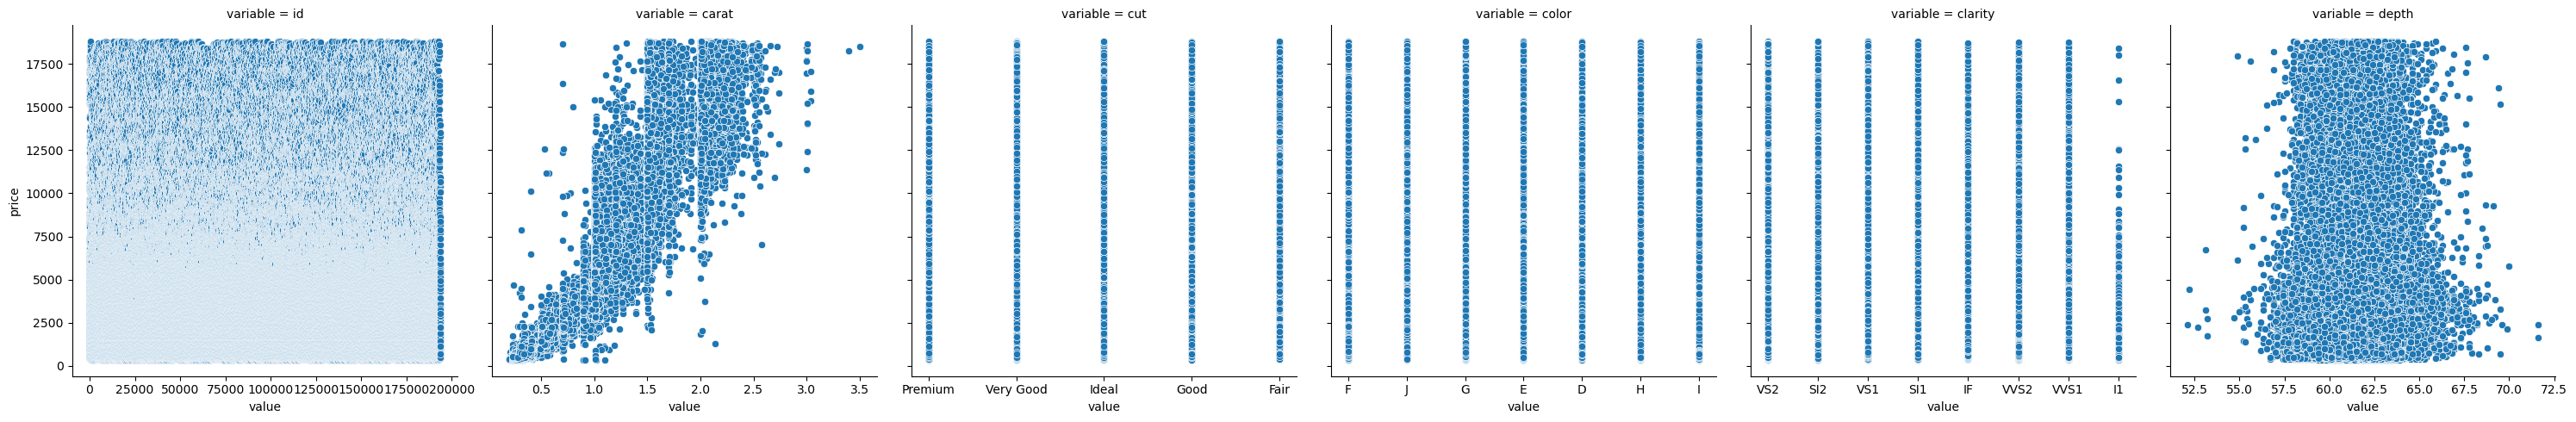

In [3]:
features = train_df.columns[0:6]
sns.relplot(
    x="value", y="price", col="variable", data=train_df.melt(id_vars="price", value_vars=features), facet_kws=dict(sharex=False),
);

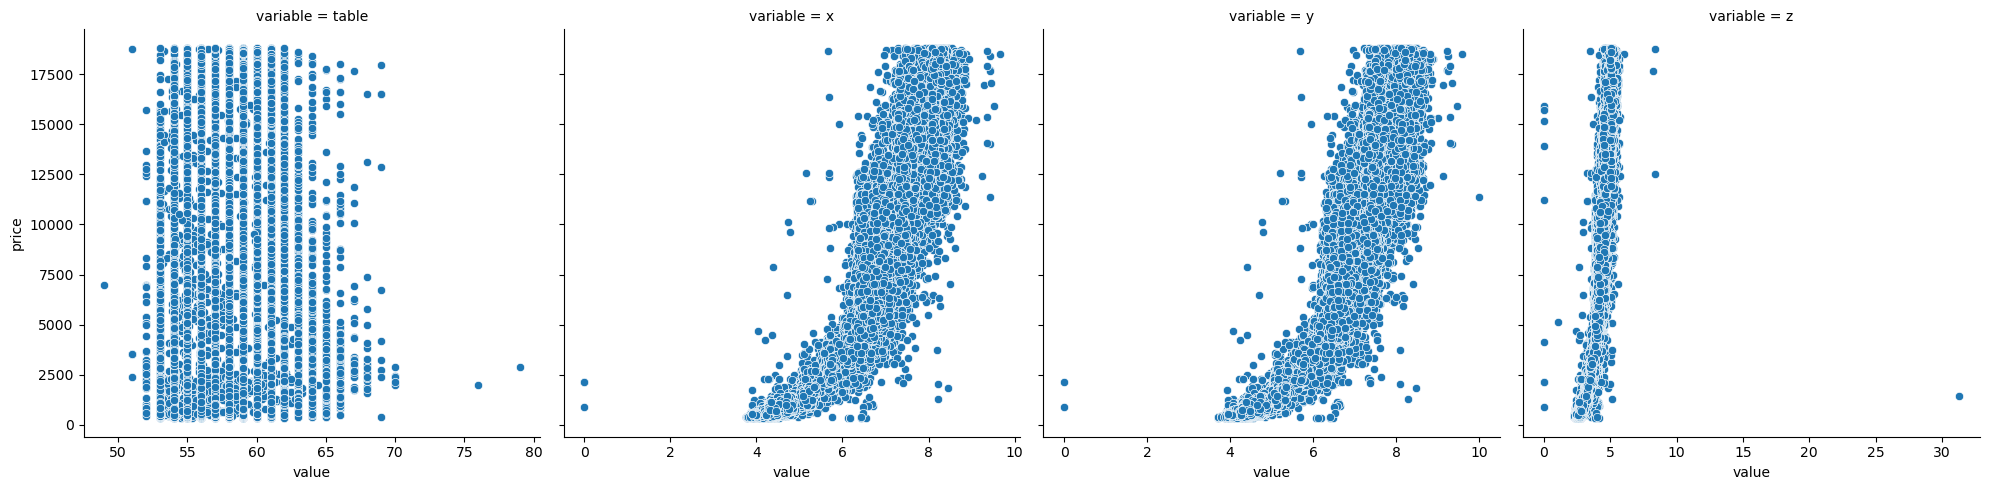

In [4]:
features = train_df.columns[6:10]
sns.relplot(
    x="value", y="price", col="variable", data=train_df.melt(id_vars="price", value_vars=features), facet_kws=dict(sharex=False),
);

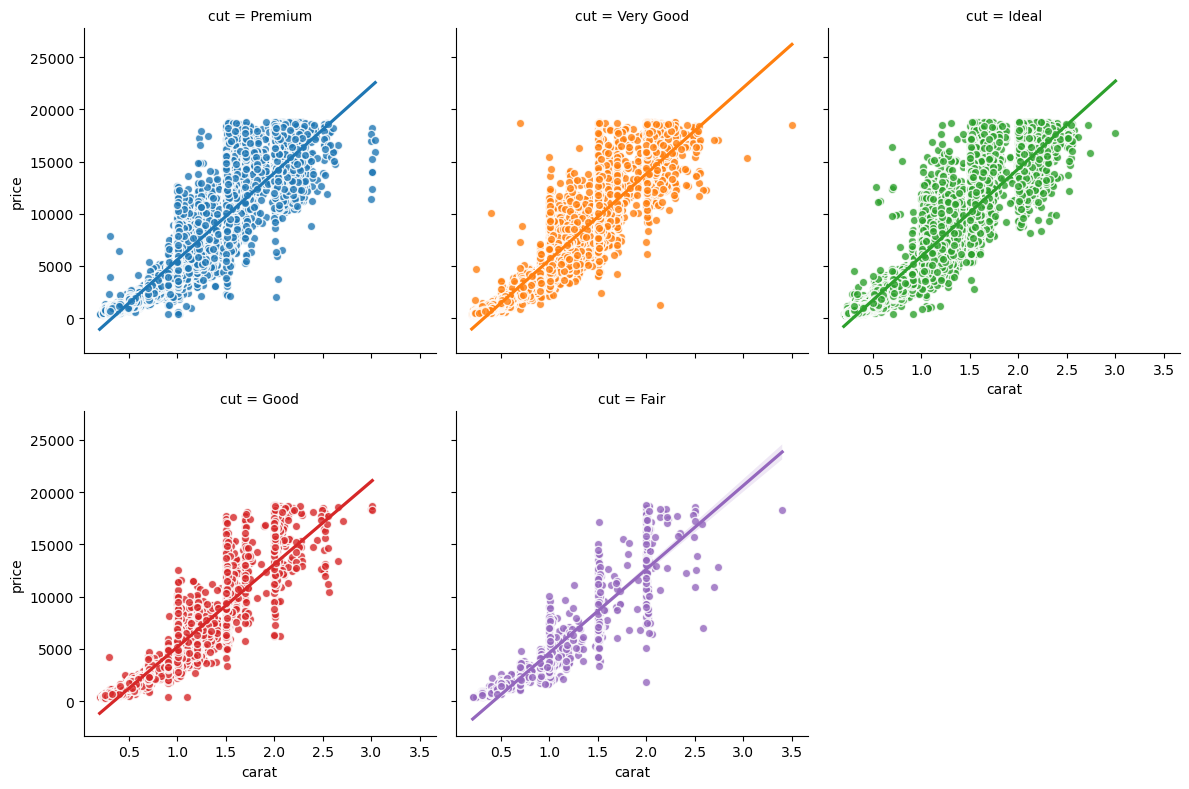

In [5]:
feature = "carat"

sns.lmplot(
    x=feature, y="price", hue="cut", col="cut",
    data=train_df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

### Features with relevance
* carat
* clarity
* depth
* x,y,z
* werwerewre

In [6]:
OUTPUT_PATH = Path.cwd().parent.resolve() / 'working'
MODEL_DIR = OUTPUT_PATH / "model"
MODEL_DIR.mkdir(exist_ok=True, parents=True)
features_path= MODEL_DIR / "x_train.csv"
labels_path=MODEL_DIR / "y_train.csv"
test_path= MODEL_DIR / "x_test.csv"
preds_save_path=MODEL_DIR / "y_preds.npy",

X = train_df.drop (columns = ['id', 'price'])
y = train_df.price
X_test = test_df.drop (columns = ['id'])

In [7]:
# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X[['cut', 'color', 'clarity']], y)
mi_scores

clarity    0.394015
color      0.283832
cut        0.092537
Name: MI Scores, dtype: float64

In [8]:
objective = 'regression'
boosting_type = 'gbdt'

def categorize_features (X: pd.DataFrame):
    obj_feat = list(X.loc[:, X.dtypes == 'object'].columns.values)
    for feature in obj_feat:
        X[feature] = pd.Series(X[feature], dtype="category")
    return X
    
def objective_lgbm(trial):
    
    param = {
        'boosting_type': boosting_type,
        'objective': objective,
        'metric': 'rmse',
        "bagging_freq": trial.suggest_int('bagging_freq', 1,10), 
        "bagging_fraction": trial.suggest_float('bagging_fraction',0.1,1),
        'num_leaves': trial.suggest_int('num_leaves', 10,100),
        'max_depth': trial.suggest_int('max_depth', 10,100),
        'min_split_gain': trial.suggest_float('min_split_gain',0.1,1),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0.1,1),
        'reg_alpha' : trial.suggest_float('reg_alpha',0.1,10),
        'reg_lambda': trial.suggest_float('reg_lambda',0.1,10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01,0.1),
        'verbosity': -1
    }
    num_boost_rounds = trial.suggest_int('num_boost_rounds', 50,400)
    model = lgb.train(param, train_data, num_boost_rounds)
    preds = model.predict(X_val)
    pred_labels = np.rint(preds)
    rmse = round(np.sqrt(mean_squared_error(y_val, pred_labels)),4)
    return rmse
    
X = categorize_features (X)
X_test = categorize_features (X_test)

print(f"Training features of shape {X.shape}")
display (X)
print(f"Training labels of shape {y.shape}")
display (y)
print(f"Test features of shape {X_test.shape}")
display (X_test)

    
X_train, X_val, y_train, y_val = train_test_split (X, y, test_size = 0.3, random_state=42)

train_data = lgb.Dataset(X_train, label = y_train)


# get best hyperparameters
study_lgbm = optuna.create_study(direction = 'minimize',study_name = "LGBM")
study_lgbm.optimize(objective_lgbm, n_trials=25)

trial_lgbm = study_lgbm.best_trial
print("Model RMSE --> ",trial_lgbm.value)
print("Model's Best parameters --> ",trial_lgbm.params)

# fit model and get score
num_boost_rounds = trial_lgbm.params['num_boost_rounds']
del trial_lgbm.params['num_boost_rounds']
trial_lgbm.params['boosting_type'] = boosting_type
trial_lgbm.params['objective'] = objective
print("Using parameters --> ",trial_lgbm.params)
model = lgb.train(trial_lgbm.params, train_data, num_boost_rounds)
pred_model = model.predict(X_val)
rmse = round(np.sqrt(mean_squared_error(y_val, pred_model)),4)
print('LightGBM Model RMSE score: {0:0.4f}'.format(rmse))

# get predictions
preds_lgbm = model.predict(X_test)
print ('Predictions: ', preds_lgbm)

Training features of shape (193573, 9)


,carat,cut,color,clarity,depth,table,x,y,z
0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55
1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05
2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50
3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71
4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77
...,...,...,...,...,...,...,...,...,...
193568,0.31,Ideal,D,VVS2,61.1,56.0,4.35,4.39,2.67
193569,0.70,Premium,G,VVS2,60.3,58.0,5.75,5.77,3.47
193570,0.73,Very Good,F,SI1,63.1,57.0,5.72,5.75,3.62
193571,0.34,Very Good,D,SI1,62.9,55.0,4.45,4.49,2.81


Training labels of shape (193573,)


0         13619
1         13387
2          2772
3           666
4         14453
          ...  
193568     1130
193569     2874
193570     3036
193571      681
193572     2258
Name: price, Length: 193573, dtype: int64

Test features of shape (129050, 9)


,carat,cut,color,clarity,depth,table,x,y,z
0,0.35,Ideal,D,VS2,62.3,56.0,4.51,4.54,2.82
1,0.77,Very Good,F,SI2,62.8,56.0,5.83,5.87,3.68
2,0.71,Ideal,I,VS2,61.9,53.0,5.77,5.74,3.55
3,0.33,Ideal,G,VVS2,61.6,55.0,4.44,4.42,2.73
4,1.20,Very Good,I,VS2,62.7,56.0,6.75,6.79,4.24
...,...,...,...,...,...,...,...,...,...
129045,0.72,Ideal,D,VVS2,62.0,56.0,5.75,5.78,3.57
129046,0.70,Premium,D,SI1,59.6,62.0,5.77,5.74,3.43
129047,1.01,Premium,G,VVS2,62.3,58.0,6.44,6.41,4.01
129048,1.35,Ideal,D,I1,62.0,56.0,7.05,7.08,4.38


[I 2023-03-21 05:49:35,185] A new study created in memory with name: LGBM
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-03-21 05:49:40,793] Trial 0 finished with value: 587.7725 and parameters: {'bagging_freq': 1, 'bagging_fraction': 0.30458693703511364, 'num_leaves': 11, 'max_depth': 81, 'min_split_gain': 0.2083368885741103, 'colsample_bytree': 0.619201021795471, 'reg_alpha': 7.836703228062605, 'reg_lambda': 0.8396718023775945, 'n_estimators': 702, 'learning_rate': 0.049011507293882234, 'num_boost_rounds': 135}. Best is trial 0 with value: 587.7725.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-03-21 05:49:56,033] Trial 1 finished 

Model RMSE -->  577.1451
Model's Best parameters -->  {'bagging_freq': 7, 'bagging_fraction': 0.894030704633314, 'num_leaves': 37, 'max_depth': 87, 'min_split_gain': 0.27627586575736307, 'colsample_bytree': 0.6962523765051951, 'reg_alpha': 4.41967116597325, 'reg_lambda': 6.148494712140688, 'n_estimators': 623, 'learning_rate': 0.01611072539062435, 'num_boost_rounds': 59}
Using parameters -->  {'bagging_freq': 7, 'bagging_fraction': 0.894030704633314, 'num_leaves': 37, 'max_depth': 87, 'min_split_gain': 0.27627586575736307, 'colsample_bytree': 0.6962523765051951, 'reg_alpha': 4.41967116597325, 'reg_lambda': 6.148494712140688, 'n_estimators': 623, 'learning_rate': 0.01611072539062435, 'boosting_type': 'gbdt', 'objective': 'regression'}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1228
[LightGBM] [Info] Number of data points in the train set:

# Submissions

In [9]:
rmse

577.1427

In [10]:
preds_lgbm = np.round(preds_lgbm, 3)
preds_lgbm

array([ 854.165, 2540.089, 2307.269, ..., 7780.944, 6768.888, 4210.698])

In [11]:
OUTPUT_PATH = Path.cwd().parent.resolve() / 'working'
submission_path = OUTPUT_PATH / 'submission.csv'
submission_df = test_df[['id']].copy()
submission_df['price'] = preds_lgbm
submission_df.to_csv (submission_path, index=False)
submission_df

,id,price
0,193573,854.165
1,193574,2540.089
2,193575,2307.269
3,193576,837.740
4,193577,5738.535
...,...,...
129045,322618,3700.382
129046,322619,2578.549
129047,322620,7780.944
129048,322621,6768.888
